In this notebook, we introduce a simplified version of the Scattering transform and its application to the classification of image textures. We show how the Scattering features of an image allow to classify correctly textures, obtaining a better performance than other features available in the sci-kit image package. As a reference we use the example at the scikit-image web page that uses Gabor filters for classifying three different textures:

   <a href='http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_gabor.html#example-features-detection-plot-gabor-py'> Gabor filter banks for texture classification </a>
    

We show, that for those 3 textures, these Gabor coefficients obtained in this tutorial perform very well, but as we augment the number of textures, the problem becomes more difficult, and the performance of the Gabor coefficients starts decending. This is not the case with the Scattering features whose classification rate is still high (~90% correctly classified).

The database used is a subset of the well know Broadtz texture database, which is online and well known as a benchmark in image classification. 

The Scattering features that we extract in this notebook are a simplification of the proposed features in 
    
   - S. Mallat. 'Group Invariant Scattering'. Comm. in Pure and Applied Math. Oct. 2012

More specifically, this coefficients are just the first layer of the Scattering transform. 
For more complicated classification 
problems, such as general image classification (CIFAR, or ImageNet databases), more advanced features are needed. For these cases, Scattering features have shown to be useful, as reported in:
    
   - J Bruna, S Mallat. 'Invariant scattering convolution networks'. TPAMI,2013
   - E Oyallon, S Mallat. 'Deep roto-translation scattering for object classification.' Proc. IEEE CVPR. 2015.




In [8]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from scipy import ndimage as ndi
import skimage 
from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel


We start by following the method proposed in the tutorial : 
<a href='http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_gabor.html#example-features-detection-plot-gabor-py'> Gabor filter banks for texture classification </a>

with a slight modification in the definition of the filter banks. 
    

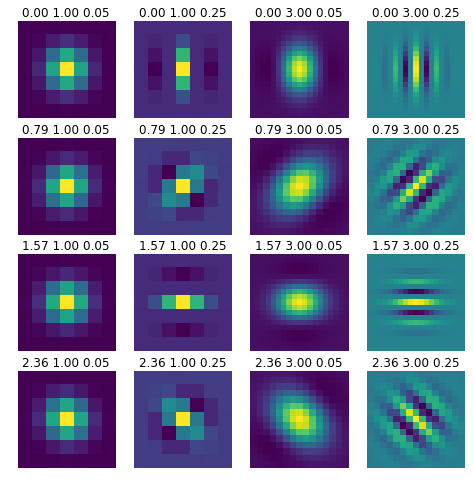

In [3]:
# Generate the filter banks defined on the example:
kernels = []
specs =[]
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = gabor_kernel(frequency, theta=theta,
                                  sigma_x=sigma, sigma_y=sigma)
            kernels.append(kernel)
            specs.append((theta, sigma, frequency))
len(kernels)

# and visualize it:
plt.figure(figsize=(8,8))
for i,(kernel, spec) in enumerate(zip(kernels, specs)):
    plt.subplot(4,4,i+1)
    plt.imshow(np.real(kernel),interpolation='nearest') 
    plt.title("%1.2f %1.2f %1.2f" % spec) #thtea sigma freq
    plt.axis('off')
    plt.viridis()

... the definition of the filter bank that we propose:

In [5]:
def create_gabor_filterbank(J=4,L=8):
    kernels =[]

    for scale in 2 ** np.arange(J) * .1:
        filter_scale = []
        kernels.append(filter_scale)
        for theta in np.arange(L) / float(L) * np.pi:
            gabor = gabor_kernel(scale, theta=theta)
            filter_scale.append(gabor)
    return kernels

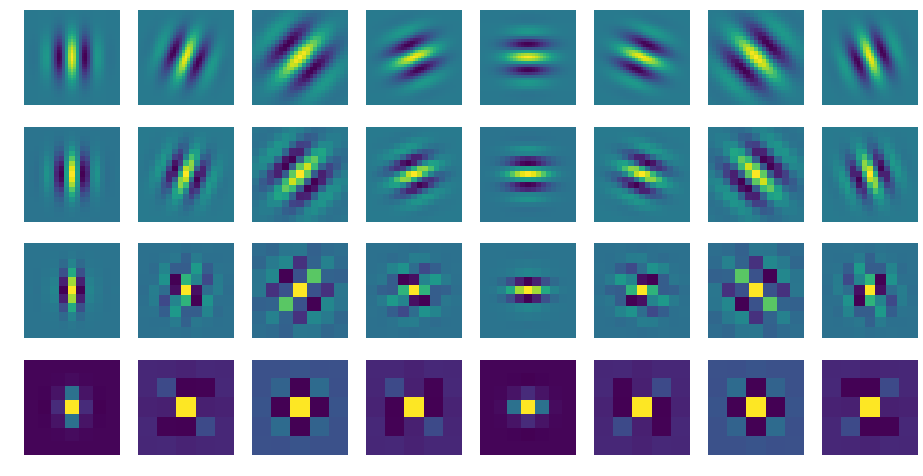

In [23]:
J=4 #number of scales
L=8 # number of angles per scale
filters = create_gabor_filterbank(J=4,L=8)

#and the visualization: 
plt.figure(figsize=(16,8))
for j,scale in enumerate(filters):
    for l,kernel in enumerate(scale):
        plt.subplot(J,L,j*L+l+1)
        plt.imshow(np.real(kernel),interpolation='nearest') 
        plt.axis('off')
        plt.viridis()
       
plt.show()

Load the 3 images in the tutorial 

In [24]:
#extract exemplar data
shrink = (slice(0, None, 1), slice(0, None, 1))
image_names = ('brick', 'grass', 'wall')
brick = img_as_float(data.load('brick.png'))[shrink]
grass = img_as_float(data.load('grass.png'))[shrink]
wall = img_as_float(data.load('rough-wall.png'))[shrink]

images = (brick, grass, wall)

Extract patches (elements to classify), and for each patch, the following features:
    - Gabor-like features
    - First order scattering coefficients
    - image patches
    
Definition of the patches: 
    - 64x64 pixels
    - stride of 1 pixel
    - extract a maximum of 100 patches per image
    

In [28]:
#Load data: extract patches and label per patch
from sklearn.feature_extraction.image import extract_patches_2d
px = 64 #patch size

brick_patches, grass_patches,wall_patches=(extract_patches_2d(image,[px, px],max_patches=100) for image in images)

all_patches = np.concatenate([brick_patches, grass_patches,wall_patches],axis=0)
all_labels = np.arange(300)//100 #assign labels to the patches from the three images

Ipermutation=np.random.permutation(len(all_patches)) #randomize the order of the patches

all_patches = all_patches[Ipermutation]
all_labels  = all_labels[Ipermutation]


In [38]:
def compute_features_example(images, filters):
    #note that the filters have different sizes, thus easier to apply the conv
    # in the spatial domain

    print('Computing the Gabor-like coefs. on ',len(images), ', this may take some time')
   
    feats = np.zeros((len(images), len(filters), len(filters[0]),2), dtype=np.float32)
    for i,image in enumerate(images):
        image_features=feats[i] #pointer
        for scale,scale_output in zip(filters,image_features):
            for kernel,kernel_l_output in zip(scale,scale_output):
                filtered = np.real(ndi.convolve(image, kernel, mode='wrap'))
                kernel_l_output[:] = filtered.mean(),filtered.var()

    return feats

In [39]:
import sys 
def compute_scattering_layer1(images, filters):
    #note that the filters have different sizes, thus easier to apply the con
    # in the spatial domain

    print('Computing the scattering coefs. on ',len(images), ' images , this may take some time')
    feats = np.zeros((len(images), len(filters), len(filters[0]),2), dtype=np.float32)
    for i,image in enumerate(images):
        image_features=feats[i] #pointer
        for scale,scale_output in zip(filters,image_features):
            for kernel,kernel_l_output in zip(scale,scale_output):
                
                # |x * psi| * phi
                filtered = np.real(np.abs(ndi.convolve(image, kernel, mode='wrap')))
                kernel_l_output[:] = filtered.mean(), (filtered ** 2).mean()

    return feats

In [40]:
#extract features 
scat_features = compute_scattering_layer1(all_patches,filters)
ex_features = compute_features_example(all_patches,filters)

scat_matrix = scat_features.reshape((len(scat_features),-1))
ex_matrix = ex_features.reshape((len(ex_features),-1))
patches_matrix = all_patches.reshape((len(all_patches),-1))


Computing the scattering coefs. on  300  images , this may take some time


/Users/ferradans/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Computing the Gabor-like coefs. on  300 , this may take some time


Compare the classification performance om the 3 image dataset of :
    - Gabor-like features
    - image patches
    
The classification performance will be obtained using a very simple classification method: logistic regression. The goal is to underline the quality of the descriptors.

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import cross_val_score, KFold, ShuffleSplit

def from_features_to_classif_scores(scat_features_b,broadtz_labels):
    #stack them for learning
    scat_features_b = scat_features_b.reshape((len(scat_features_b),-1))
    # apply pipeline
    n = len(scat_features_b)
    pipeline = make_pipeline(Normalizer(),StandardScaler(),LogisticRegression(C=1.0))
    cv = ShuffleSplit(n,n_iter=3,test_size=1, train_size=1)
    
    scat_scores_b = cross_val_score(pipeline,scat_features_b,broadtz_labels,cv=5,n_jobs=5)
    print('score:',scat_scores_b)



In [42]:
print('Example initial BD:')
from_features_to_classif_scores(ex_features,all_labels)

print('Scat initial BD:')
from_features_to_classif_scores(scat_features,all_labels)

print('Patches initial BD:')
from_features_to_classif_scores(all_patches,all_labels)


Example initial BD:
score: [ 1.  1.  1.  1.  1.]
Scat initial BD:
score: [ 1.  1.  1.  1.  1.]
Patches initial BD:
score: [ 0.61666667  0.61666667  0.6         0.53333333  0.65      ]


We can see that in this simple example, the scattering and the Gabor-like features perform perfectly. We are now going to augment the data set to more textures (Broadtz data set) to see how the scattering coefficients, in fact, can outperform this very simple Gabor-like features

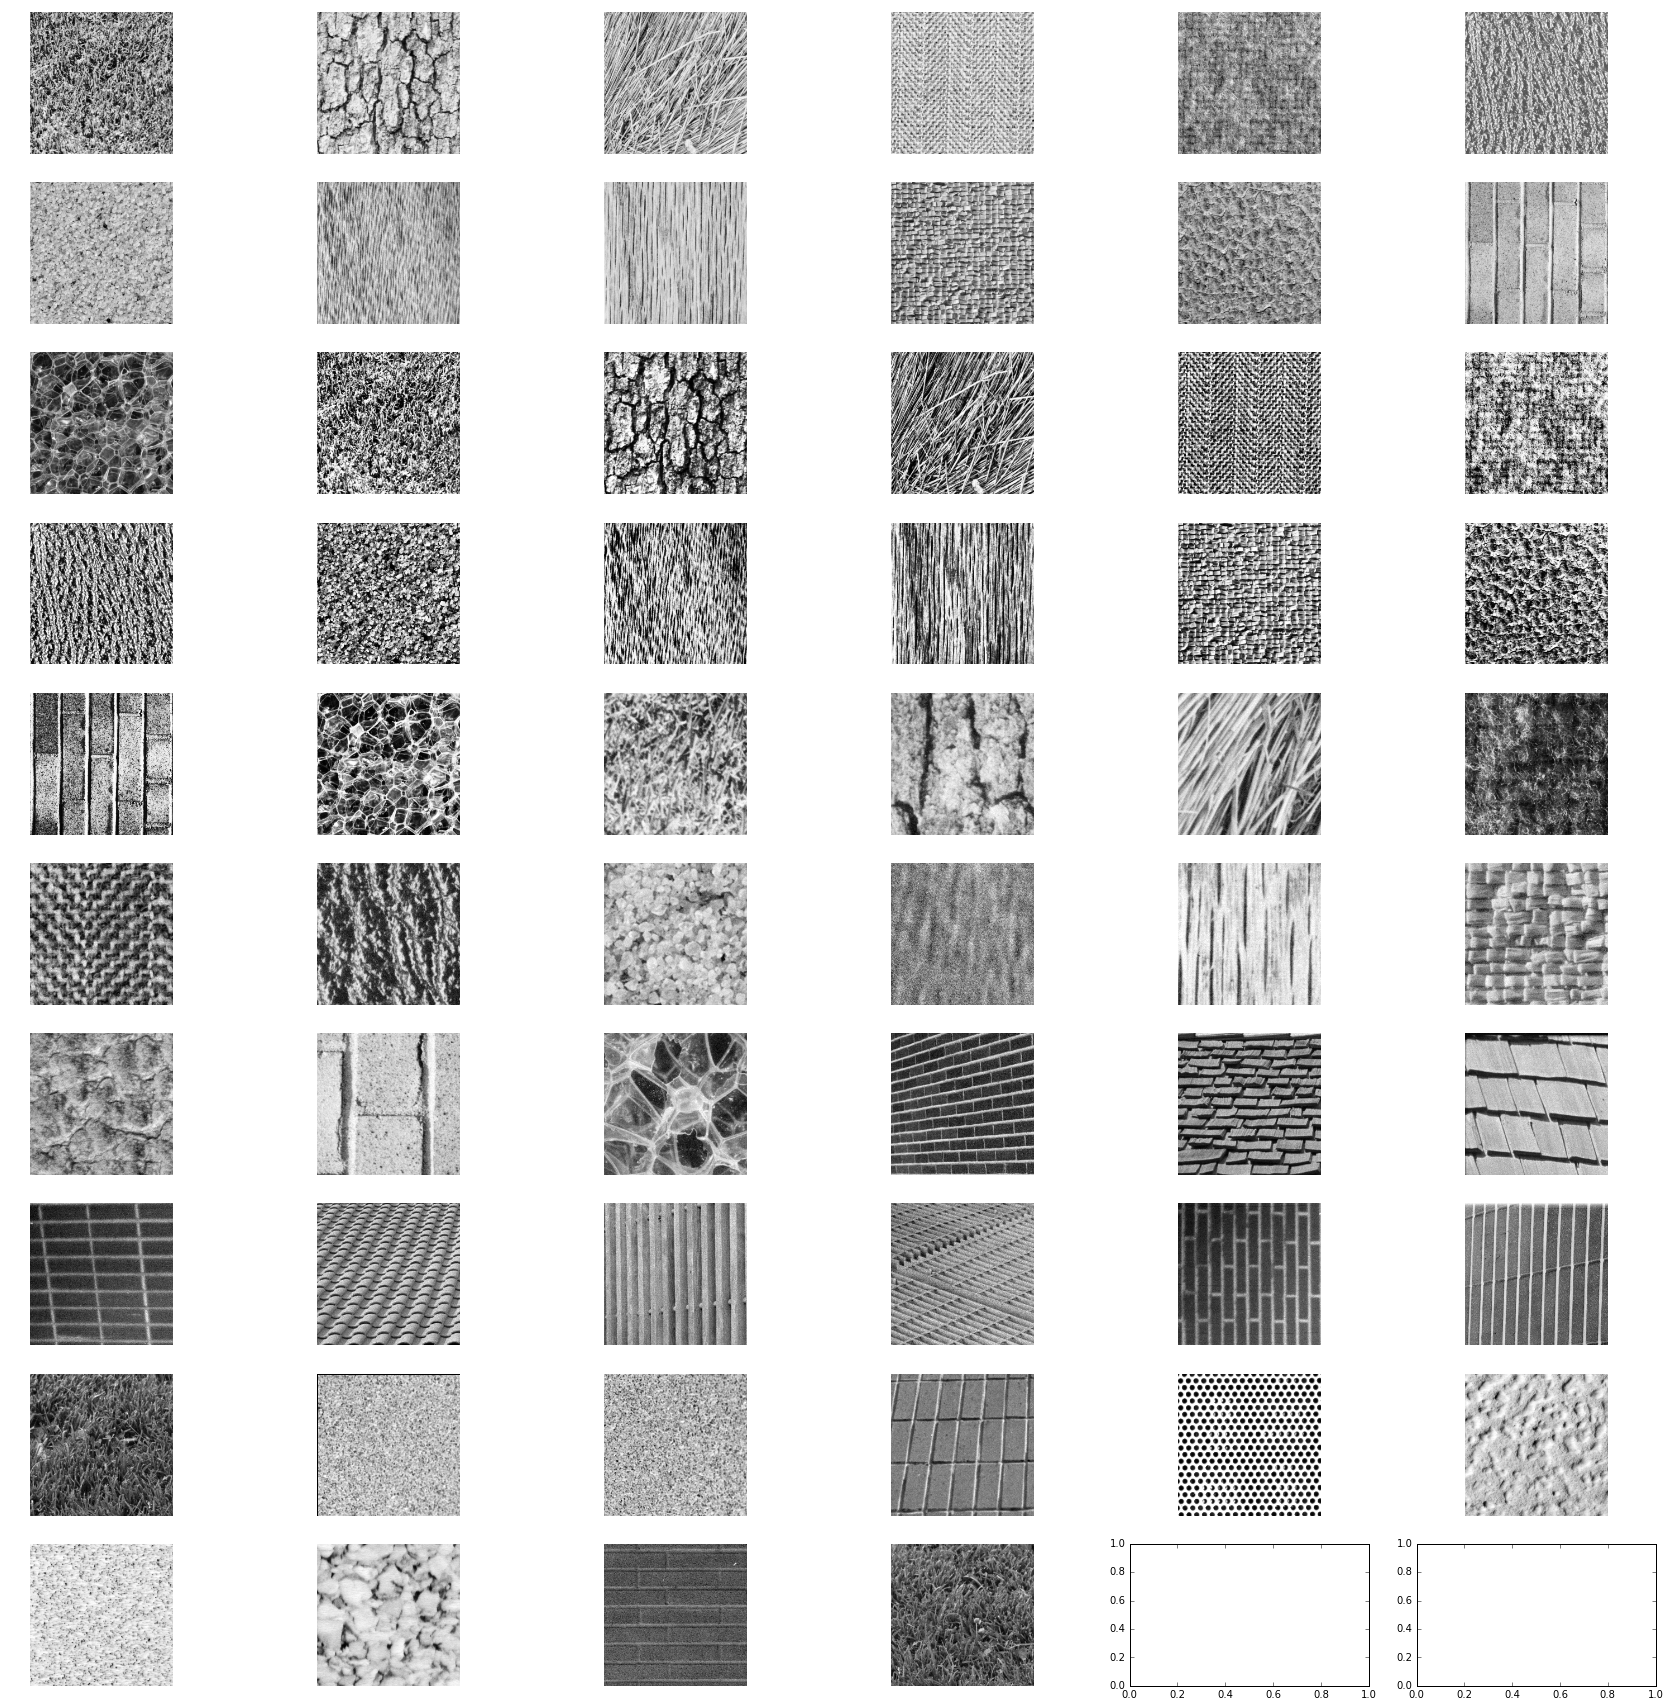

In [43]:
#New database
import scipy.misc
import glob
files = glob.glob('./textures/*.tiff')
broadtz_patches  = []
broadtz_labels = []
view_images = bool(1)
if view_images: 
    fig, axes = plt.subplots(nrows=10, ncols=6, figsize=(30, 30))
    AX = axes.ravel()
for i,file in enumerate(files):
    aa = data.imread(file)
  
    aa = aa[:256,:256]
    aa.shape
    broadtz_patches.append(extract_patches_2d(aa,[px, px],max_patches=50))
    broadtz_labels.append([i]*len(broadtz_patches[-1]))
    if view_images :
        AX[i].imshow(aa, cmap='gray')
        AX[i].axis('off')
    
broadtz_labels = np.concatenate(broadtz_labels, axis=0)
broadtz_patches= np.concatenate(broadtz_patches,axis=0)
#preprocessing:take out the mean of each patch: we want to be indep. from illumination changes
brodatz_means = broadtz_patches.reshape(len(broadtz_patches), -1).mean(1).astype('float32')
broadtz_patches = broadtz_patches - brodatz_means[:, np.newaxis, np.newaxis]


In [44]:
#get features
scat_features_b=compute_scattering_layer1(broadtz_patches,filters)
ex_features_b=compute_features_example(broadtz_patches,filters)

Computing the scattering coefs. on  2900  images , this may take some time


/Users/ferradans/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Computing the Gabor-like coefs. on  2900 , this may take some time


Finally, obtain the classification scores using the scattering coefficients and the Gabor-like features. 

In [46]:
print('Classification performance for Gabor-like features on new BD:')
from_features_to_classif_scores(ex_features_b,broadtz_labels)

print('Classification performance for Scattering features on new BD:')
from_features_to_classif_scores(scat_features_b,broadtz_labels)


Classification performance for Gabor-like features on new BD:
score: [ 0.70862069  0.67241379  0.70517241  0.69137931  0.69655172]
Classification performance for Scattering features on new BD:
score: [ 0.94482759  0.97068966  0.96206897  0.9637931   0.96896552]
